In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [3]:
import zipfile
import os

with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("data")

os.listdir("data")

['PJMW_hourly.csv',
 'DUQ_hourly.csv',
 'est_hourly.paruqet',
 'COMED_hourly.csv',
 'AEP_hourly.csv',
 'PJME_hourly.csv',
 'NI_hourly.csv',
 'FE_hourly.csv',
 'DOM_hourly.csv',
 'pjm_hourly_est.csv',
 'DAYTON_hourly.csv',
 'EKPC_hourly.csv',
 'DEOK_hourly.csv',
 'PJM_Load_hourly.csv']

In [4]:
df = pd.read_csv("data/AEP_hourly.csv")
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [5]:
df.shape

(121273, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.isna().sum()

,0
Datetime,0
AEP_MW,0


DATA PREPROCESSING

In [9]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [10]:
df.set_index('Datetime', inplace=True)

In [11]:
df.sort_index(inplace=True)

In [12]:
df = df.ffill()

EXPLORATORY DATA ANALYSIS (EDA)

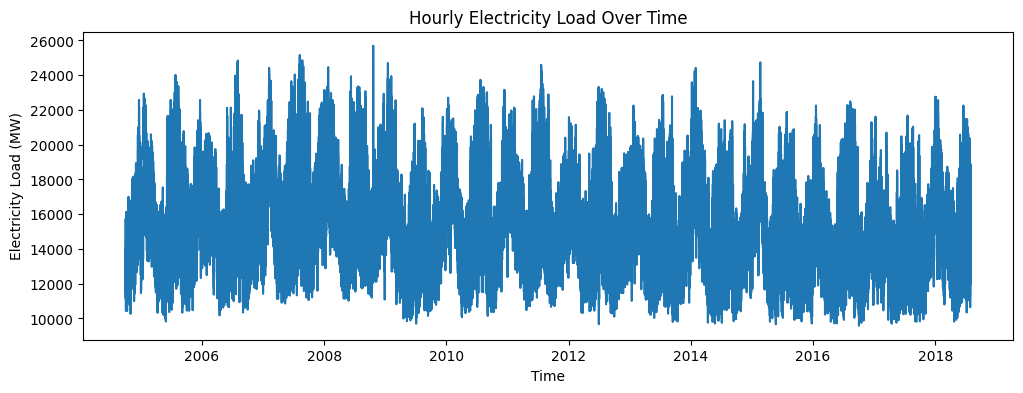

In [13]:
# Plot 1: Load vs Time (Full Time Series)
plt.figure(figsize=(12,4))
plt.plot(df.index, df['AEP_MW'])
plt.xlabel("Time")
plt.ylabel("Electricity Load (MW)")
plt.title("Hourly Electricity Load Over Time")
plt.show()

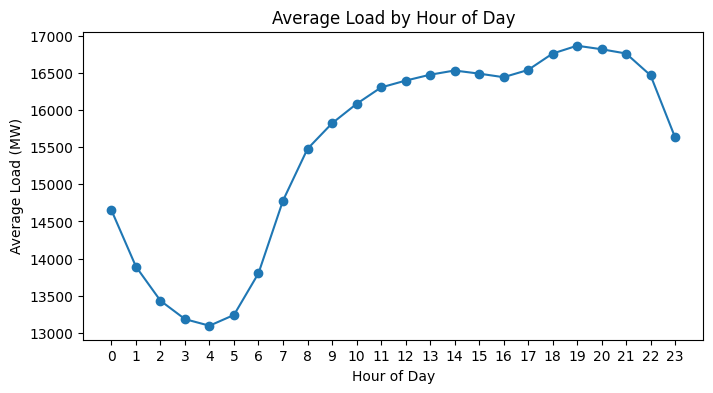

In [14]:
# Plot 2: Average Load by Hour of Day
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['AEP_MW'].mean()

plt.figure(figsize=(8,4))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.xlabel("Hour of Day")
plt.ylabel("Average Load (MW)")
plt.title("Average Load by Hour of Day")
plt.xticks(range(0,24))
plt.show()

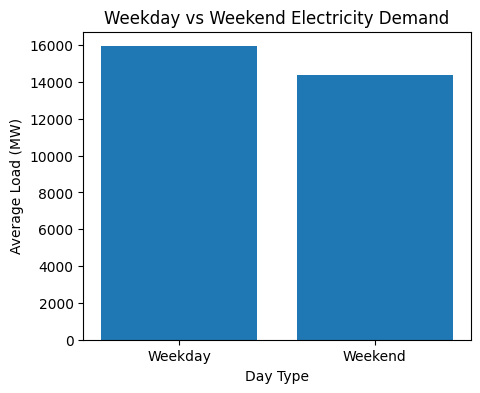

In [15]:
# Plot 3: Weekday vs Weekend Load
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

daytype_avg = df.groupby('is_weekend')['AEP_MW'].mean()

plt.figure(figsize=(5,4))
plt.bar(['Weekday', 'Weekend'], daytype_avg.values)
plt.xlabel("Day Type")
plt.ylabel("Average Load (MW)")
plt.title("Weekday vs Weekend Electricity Demand")
plt.show()

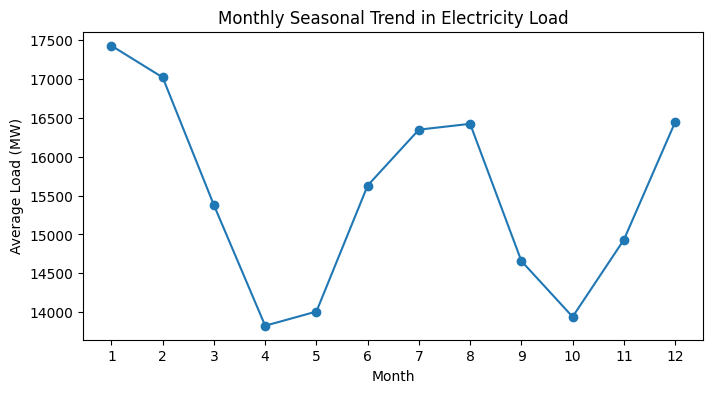

In [16]:
# Plot 4: Monthly Seasonal Trend
df['month'] = df.index.month
monthly_avg = df.groupby('month')['AEP_MW'].mean()

plt.figure(figsize=(8,4))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.xlabel("Month")
plt.ylabel("Average Load (MW)")
plt.title("Monthly Seasonal Trend in Electricity Load")
plt.xticks(range(1,13))
plt.show()

FEATURE ENGINEERING (CORE PART)

In [17]:
# Time-Based Features
df['day'] = df.index.day

In [18]:
# Lag Features
df['lag_1'] = df['AEP_MW'].shift(1)
df['lag_24'] = df['AEP_MW'].shift(24)
df['lag_168'] = df['AEP_MW'].shift(168)


In [19]:
# Rolling Statistics
df['rolling_mean_24'] = df['AEP_MW'].rolling(window=24).mean()
df['rolling_mean_168'] = df['AEP_MW'].rolling(window=168).mean()
df['rolling_std_24'] = df['AEP_MW'].rolling(window=24).std()

In [20]:
# Remove Rows with NaN (From Lag & Rolling Features)
df = df.dropna()

In [21]:
df.head()

,AEP_MW,hour,day_of_week,is_weekend,month,day,lag_1,lag_24,lag_168,rolling_mean_24,rolling_mean_168,rolling_std_24
Datetime,,,,,,,,,,,,
2004-10-08 01:00:00,12468.0,1,4,0,10,8,13271.0,12484.0,12379.0,14449.666667,13870.845238,1476.478821
2004-10-08 02:00:00,12046.0,2,4,0,10,8,12468.0,12054.0,11935.0,14449.333333,13871.505952,1477.043983
2004-10-08 03:00:00,11749.0,3,4,0,10,8,12046.0,11745.0,11692.0,14449.500000,13871.845238,1476.725755
2004-10-08 04:00:00,11784.0,4,4,0,10,8,11749.0,11757.0,11597.0,14450.625000,13872.958333,1474.594117
2004-10-08 05:00:00,11919.0,5,4,0,10,8,11784.0,12041.0,11681.0,14445.541667,13874.375000,1483.445636


In [22]:
df.shape

(121105, 12)

TIME-BASED TRAIN–TEST SPLIT

In [23]:
target = 'AEP_MW'

features = [
    'hour', 'day', 'day_of_week', 'month', 'is_weekend',
    'lag_1', 'lag_24', 'lag_168',
    'rolling_mean_24', 'rolling_mean_168', 'rolling_std_24'
]

X = df[features]
y = df[target]


In [24]:
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

In [25]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred_lr = lr_model.predict(X_test)

In [27]:
# Evaluate Linear Regression (MAE & RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression MAE :", lr_mae)
print("Linear Regression RMSE:", lr_rmse)


Linear Regression MAE : 376.28483991519147
Linear Regression RMSE: 477.38221470443074


In [28]:
# Train Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [29]:
y_pred_rf = rf_model.predict(X_test)

In [30]:
# Evaluate Random Forest (MAE & RMSE)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest MAE :", rf_mae)
print("Random Forest RMSE:", rf_rmse)

Random Forest MAE : 140.64510507410927
Random Forest RMSE: 194.2587951412443


In [31]:
# Model Comparison Table
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [lr_mae, rf_mae],
    'RMSE': [lr_rmse, rf_rmse]
})

comparison

,Model,MAE,RMSE
0,Linear Regression,376.284840,477.382215
1,Random Forest,140.645105,194.258795


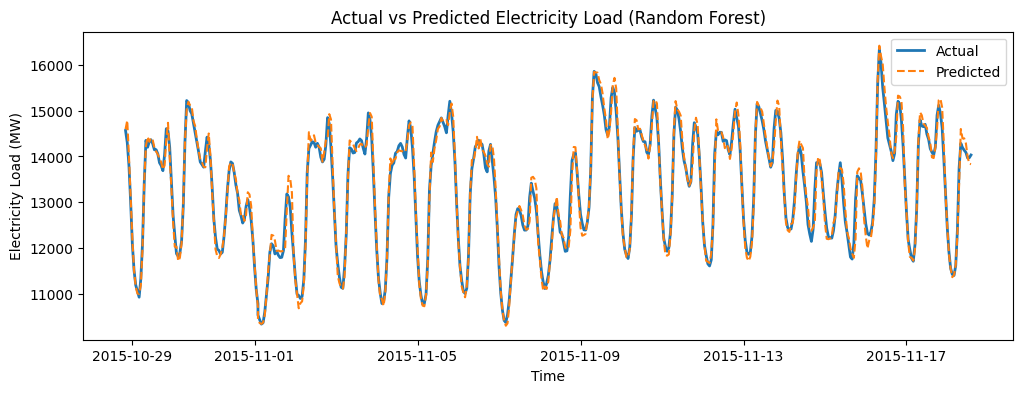

In [32]:
# Actual vs Predicted Load (Random Forest)
plt.figure(figsize=(12,4))
plt.plot(y_test.index[:500], y_test.values[:500], label='Actual', linewidth=2)
plt.plot(y_test.index[:500], y_pred_rf[:500], label='Predicted', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Electricity Load (MW)")
plt.title("Actual vs Predicted Electricity Load (Random Forest)")
plt.legend()
plt.show()

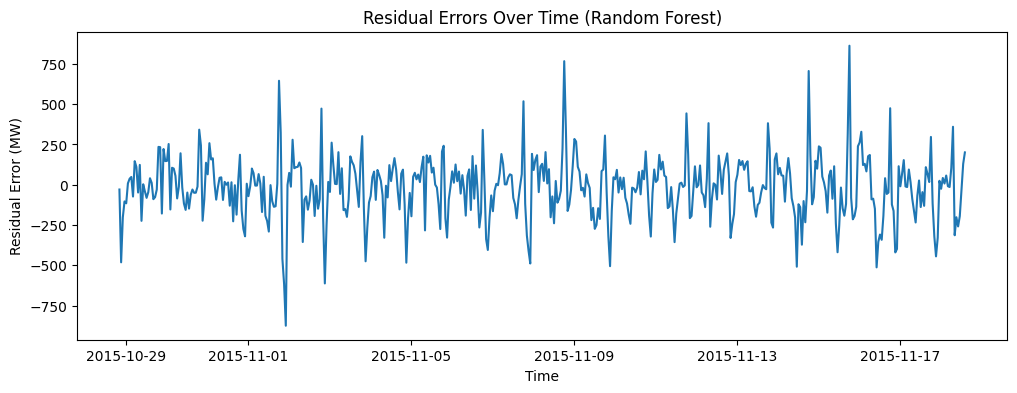

In [33]:
# Residual Error Analysis
residuals = y_test - y_pred_rf

plt.figure(figsize=(12,4))
plt.plot(residuals.index[:500], residuals.values[:500])
plt.xlabel("Time")
plt.ylabel("Residual Error (MW)")
plt.title("Residual Errors Over Time (Random Forest)")
plt.show()

In [34]:
# NEXT CELL — Advanced Model: Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42)

In [36]:
# Predict & Evaluate Gradient Boosting Model

# Predict on test set
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate performance
gbr_mae = mean_absolute_error(y_test, y_pred_gbr)
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))

print("Gradient Boosting MAE :", gbr_mae)
print("Gradient Boosting RMSE:", gbr_rmse)


Gradient Boosting MAE : 226.69777139386412
Gradient Boosting RMSE: 292.09618133120733


In [37]:
# Final Model Comparison (ALL MODELS)
final_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MAE': [lr_mae, rf_mae, gbr_mae],
    'RMSE': [lr_rmse, rf_rmse, gbr_rmse]
})

final_comparison


,Model,MAE,RMSE
0,Linear Regression,376.284840,477.382215
1,Random Forest,140.645105,194.258795
2,Gradient Boosting,226.697771,292.096181
